#### In this notebook, you can find various functions and code for exploring and analysing your initial scan images data

## EDA on the bifurcation point detection raw dataset (from orCaScore)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

import utils

In [8]:
# Load all ct scan files
DATA_PATH = r'C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\bifurcation_point'

image_paths = []
for folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(".nii"):
                image_paths.append(os.path.join(folder_path, filename))

In [9]:
# Load scan image data
scans, shapes, spacings = [], [], []
for im_path in image_paths:
  ct_scan, spacing = utils.read_nifti_image(im_path, spacing=True)
  scans.append(ct_scan)
  shapes.append(ct_scan.shape)
  spacings.append(spacing)


In [10]:
# Check for inconsistency in [z, w, h] of images
print("Min shape: ", min(shapes))
print("Max shape: ", max(shapes))
dims_df = pd.DataFrame(shapes, columns=['z', 'height', 'width'])
dims_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})

Min shape:  (36, 512, 512)
Max shape:  (64, 512, 512)


,height,width,count
0,512,512,31


We can see that all of the 31 scans have consistent width and height (512 by 512 pixels), though the number of slices vary from 36 to 64, let's plot number of slices to have a better visualization

In [11]:
print("Total number of slices: ", dims_df['z'].sum())

Total number of slices:  1498


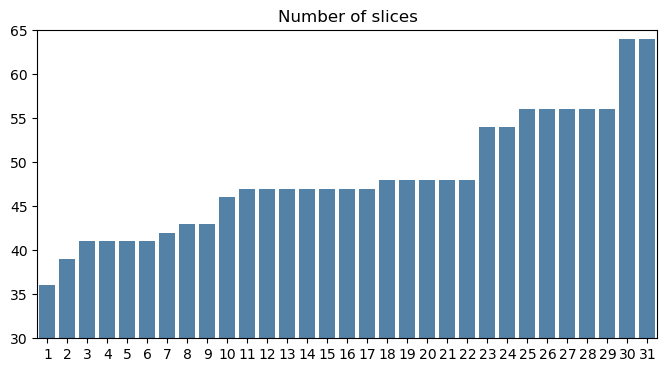

In [10]:
#plot number of slice distribution
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=[x for x in range(1, 32)], y=sorted(dims_df['z']), ax=ax, color='steelblue')
plt.ylim(30, 65)
plt.title("Number of slices")
plt.show()

In [12]:
def visualize_intensity(scans, row=3, col=4, xmin=-300, xmax=400):
  fig, ax = plt.subplots(row, col, figsize=(col*3,row*2))
  fig.suptitle("Pixel intensity visualization")
  n = 0
  for i in range(row):
    for k in range(col):
      ax[i,k].hist((scans[n]).ravel(), xmax-xmin, [xmin, xmax], color='steelblue')
      ax[i,k].set_ylabel("Number Of Pixels")
      ax[i,k].set_xlabel(f"Pixel Intensity from {xmin} to {xmax}")
      ax[i,k].set_title(image_paths[n].split('\\')[-1])
      n = n + 1
  fig.tight_layout()
  plt.show()


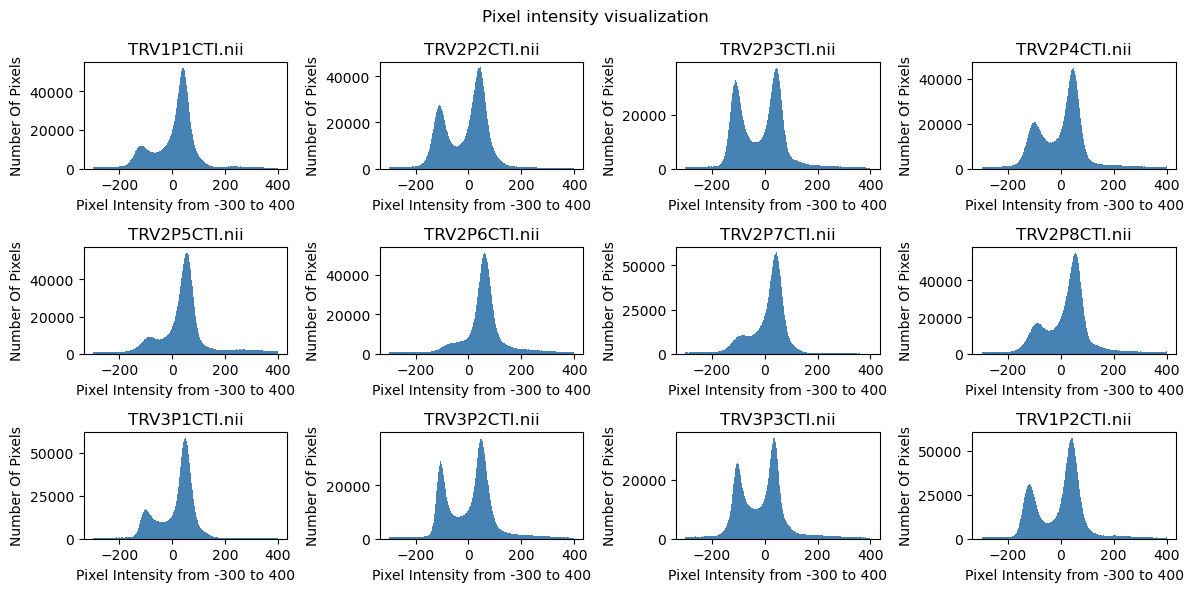

In [13]:
#Visualizing pixel intensity distribution
visualize_intensity(scans)

The HU values usually fall between -1000, 1000, anything above or below is considered outliers or error. Let's check for outliers, we want to cut intensity to be in the acceptable range in the preprocessing step

In [26]:
def visualize_intensity_range(scans):
    line = []
    x = []
    for i in range(len(scans)):
        line.append(scans[i].ravel().max())
        line.append(scans[i].ravel().min())
        x.append(i)
        x.append(i)

    sns.lineplot(x=x, y=(line))
    plt.xlabel("# scan")
    plt.ylabel("Intensity range")
    plt.show()


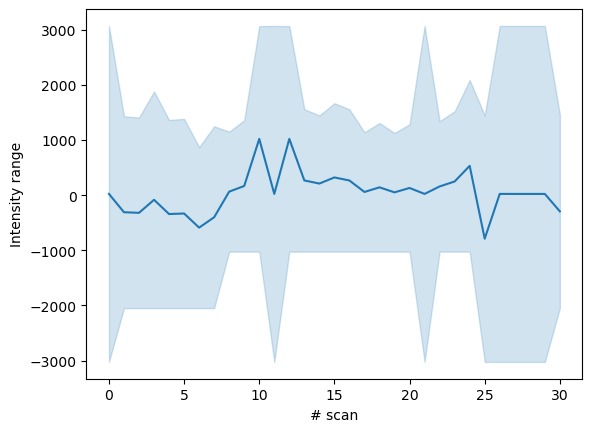

In [27]:
visualize_intensity_range(scans)

We can see that intensity ranges as much as below -3000 and above +3000 for some scan images <br>
Now let's see if the spacing is consistent across all scan images

In [16]:
spacing_df = pd.DataFrame(spacings, columns=['z', 'x', 'y'])
spacing_df.groupby(['x', 'y', 'z']).size().reset_index().rename(columns={0:'count'})

,x,y,z,count
0,0.328125,0.328125,3.0,1
1,0.353516,0.353516,3.0,1
2,0.373047,0.373047,3.0,1
3,0.382812,0.382812,3.0,2
4,0.386719,0.386719,3.0,1
5,0.392578,0.392578,3.0,1
6,0.410156,0.410156,2.5,1
7,0.417969,0.417969,3.0,1
8,0.419922,0.419922,2.5,1
9,0.425781,0.425781,2.5,1


## EDA on the aorta dataset and segmentation masks

In [34]:
# Load all ct scan files
AORTA_DATA_PATH = r'C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\aorta'

image_paths_aorta = []
mask_paths = []
for folder in os.listdir(AORTA_DATA_PATH):
    folder_path = os.path.join(AORTA_DATA_PATH, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if filename == 'og_ct.nii':
                image_paths_aorta.append(file_path)
            elif filename == 'aorta_mask.nii':
                mask_paths.append(file_path)

assert len(image_paths_aorta) == len(mask_paths)
len(image_paths_aorta)

30

In [35]:
# Load scan image data and spacing
scans_aorta, shapes_aorta, spacings_aorta = [], [], []
masks = []
for i in range(len(image_paths_aorta)):
  ct_im, spacing_im = read_image(image_paths_aorta[i])
  mask, spacing_mask = read_image(mask_paths[i])
  assert ct_im.shape == mask.shape, f'CT image and the mask doesnt have equal size respectively at: {image_paths_aorta[i]} and {mask_paths[i]}'
  assert all(spacing_im == spacing_mask), f'CT image and the mask doesnt have equal spacing respectively at: {image_paths_aorta[i]} and {mask_paths[i]}'
  scans_aorta.append(ct_im)
  masks.append(mask)
  shapes_aorta.append(ct_im.shape)
  spacings_aorta.append(spacing_im)

In [36]:
# Check for inconsistency in [z, w, h] of images
print("Min shape: ", min(shapes_aorta))
print("Max shape: ", max(shapes_aorta))
dims_aorta_df = pd.DataFrame(shapes_aorta, columns=['z', 'height', 'width'])
dims_aorta_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})

Min shape:  (43, 512, 512)
Max shape:  (54, 512, 512)


,height,width,count
0,512,512,30


In [37]:
spacing_aorta_df = pd.DataFrame(spacings_aorta, columns=['z', 'x', 'y'])
spacing_aorta_df.groupby(['x', 'y', 'z']).size().reset_index().rename(columns={0:'count'})

,x,y,z,count
0,0.285,0.285,3.0,1
1,0.332,0.332,3.0,2
2,0.351,0.351,3.0,1
3,0.356,0.356,3.0,2
4,0.358,0.358,3.0,2
5,0.368,0.368,3.0,2
6,0.376,0.376,3.0,1
7,0.378,0.378,3.0,1
8,0.380,0.380,3.0,1
9,0.388,0.388,3.0,2


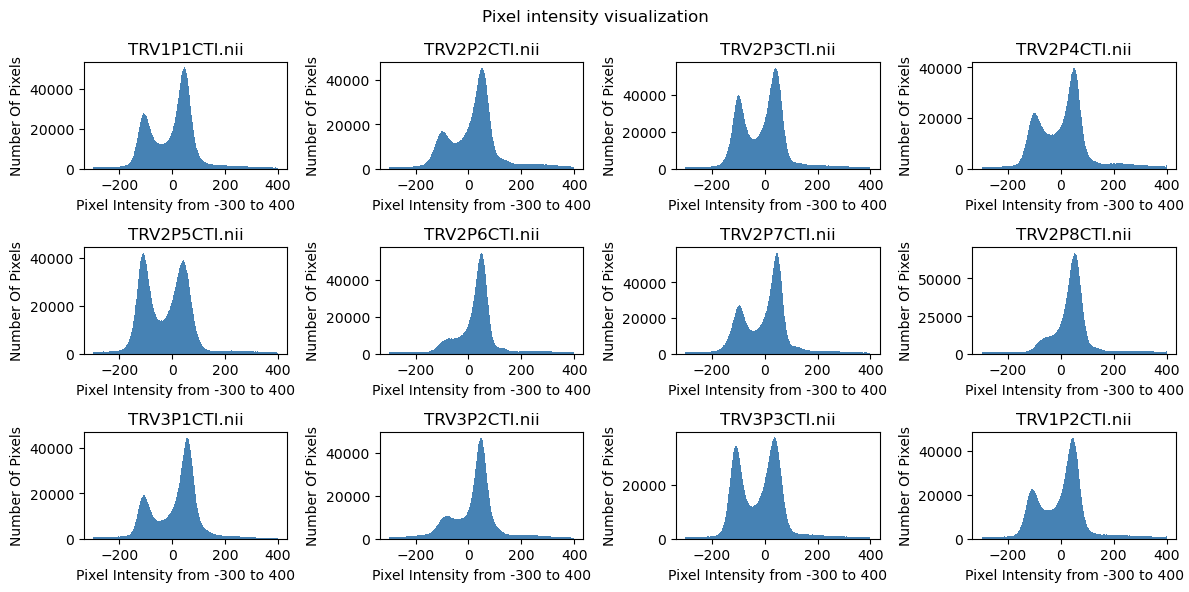

In [21]:
visualize_intensity(scans_aorta)

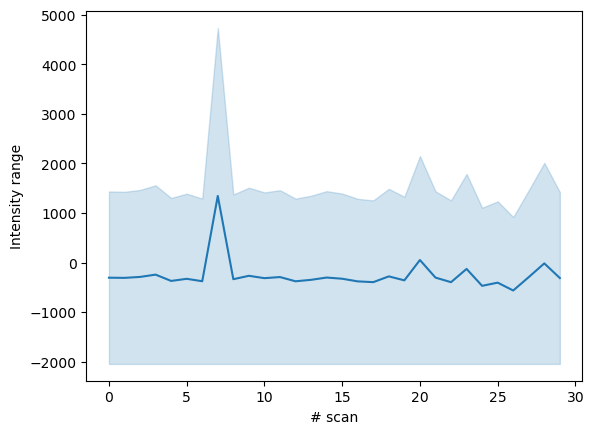

In [42]:
visualize_intensity_range(scans_aorta)

In [38]:
def count_mask_slices(mask):
    """Given a mask of shape 3D, return a count of number of slices that contain a segmentation"""
    count = 0
    for i in range(mask.shape[0]):
        if sum(mask[i].ravel() > 0): #if there is a segmentation mask in slice i
            count = count + 1
    return count

In [45]:
masks_size = []
non_zero_masks =[]
for i in range(len(masks)):
    masks_size.append(masks[i].shape[0])
    non_zero_masks.append(count_mask_slices(masks[i]))


In [85]:
print(f"Total number of slices across {len(masks_size)} CT images: ", sum(masks_size))
print('Total sum of slices with segmentation masks: ', sum(non_zero_masks))
print("Ratio: ", sum(non_zero_masks) / sum(masks_size) * 100)

Total number of slices across 30 CT images:  1469
Total sum of slices with segmentation masks:  649
Ratio:  44.179714091218514


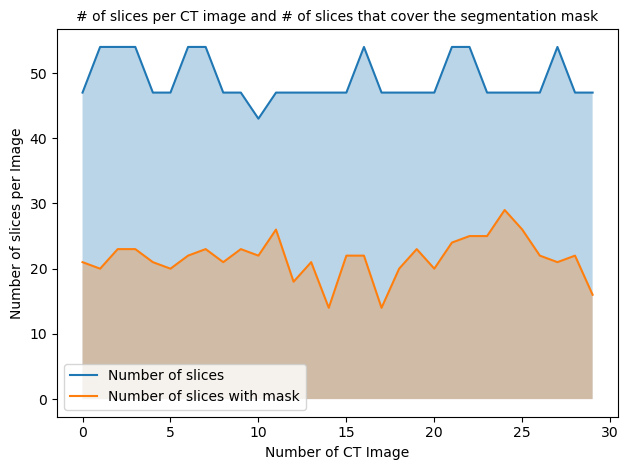

In [79]:
x = [x for x in range(len(masks_size))]
plt.plot(masks_size, label='Number of slices')
plt.fill_between(x, masks_size, alpha=0.3)
plt.plot(non_zero_masks, label='Number of slices with mask')
plt.fill_between(x, non_zero_masks, alpha=0.3)
plt.title("# of slices per CT image and # of slices that cover the segmentation mask", fontsize=10)
plt.xlabel("Number of CT Image")
plt.ylabel("Number of slices per Image")
plt.tight_layout()
plt.legend()
plt.show()

So far we have:
1. Confirmed that each CT image and its corresponsing mask has the same size and spacing
2. All of the image slices are same sized (512, 512)
3. The spacing actoss z direction is consistent == 3.0, however spacing across x and y directions vary from 0.285 to 0.473
4. Plotted pixel intensity histogram, and verified not all the images follow the same distribution. We might consider implementing methods like histogram matching, maximum intensty projection etc
5. There are outliners in terms of intensity shooting all the way up to 5000
6. Calculated the number of slices with segmentation mask for each CT image and saw that distribution is not consistent over all images (this is not really a problem)
7. Only 44% of slices across all dataset will have ground truth labels (since emtpy text file for slices with no present targeted structure). We might want to oversample slice images with labels